In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.graph_objs as go
%matplotlib inline

In [3]:
# Import et aperçu des datasets
df_2024_Table = pd.read_excel("DataForTable2.1.xls")
df_continents = pd.read_csv("continents2.csv")

display(df_2024_Table.head())
display(df_continents.head())

FileNotFoundError: [Errno 2] No such file or directory: 'DataForTable2.1.xls'

________________________________

## Nettoyage des données

In [5]:
# Correspondance des noms de pays
df_2024_Table['Country name'] = df_2024_Table['Country name'].replace({'Türkiye':'Turkey',
                                                                       'Taiwan Province of China':'Taiwan',
                                                                       'Hong Kong S.A.R. of China':'Hong Kong'
                                                                       })

df_continents['name'] = df_continents['name'].replace({'Bosnia And Herzegovina':'Bosnia and Herzegovina',
                                                       'Congo (Democratic Republic Of The)':'Congo (Brazzaville)',
                                                       'Congo':'Congo (Kinshasa)',
                                                       "Côte D'Ivoire":'Ivory Coast',
                                                       'Czech Republic':'Czechia',
                                                       'Macedonia':'North Macedonia',
                                                       'Palestine, State of':'State of Palestine'
                                                       })

# Merge des 2 datasets
df_2024 = pd.merge(df_2024_Table, df_continents[['name', 'region','sub-region']], left_on = "Country name", right_on = "name", how = 'left')

# Drop colonne "name"
df_2024.drop(columns='name', inplace=True)

# Ordre et casse des colonnes
df_2024 = df_2024[['Country name', 'region', 'sub-region'] + [col for col in df_2024.columns if col not in ['Country name', 'region', 'sub-region']]]

df_2024 = df_2024.rename(columns={'region': 'Region', 'sub-region': 'Sub region', 'year': 'Year'})

# Ajout données Kosovo
df_2024.loc[df_2024['Country name'] == 'Kosovo', ['Region', 'Sub region']] = ['Europe', 'Southern Europe']

# Conservation des 10 dernières années 
df_2024 = df_2024.drop(df_2024[df_2024.Year < 2014].index)

## Modélisation

#### Préprocessing

##### Import des packages

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Préparation des données

In [7]:
# Drop des colonnes  Country name, Region et Sub region
df = df_2024.drop(['Year', 'Country name', 'Region', 'Sub region'], axis = 1)

In [64]:
# Séparation en deux dataframe

feats = df.drop('Life Ladder', axis=1)
target = df['Life Ladder']


# Séparation en données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state = 42)


In [63]:
df.isna().sum()

Life Ladder                          0
Log GDP per capita                  22
Social support                       5
Healthy life expectancy at birth    35
Freedom to make life choices        20
Generosity                          30
Perceptions of corruption           77
Positive affect                     10
Negative affect                      9
dtype: int64

In [66]:
df.isna().any(axis=1).sum()

136

In [74]:
# Gestion valeurs manquantes

imputer = SimpleImputer(missing_values=np.nan, strategy='median')

X_train = imputer.fit_transform(X_train)

X_test = imputer.transform(X_test)



In [70]:
display(X_train.shape)
display(X_test.shape)

(1099, 8)

(275, 8)

#### Linear Regression

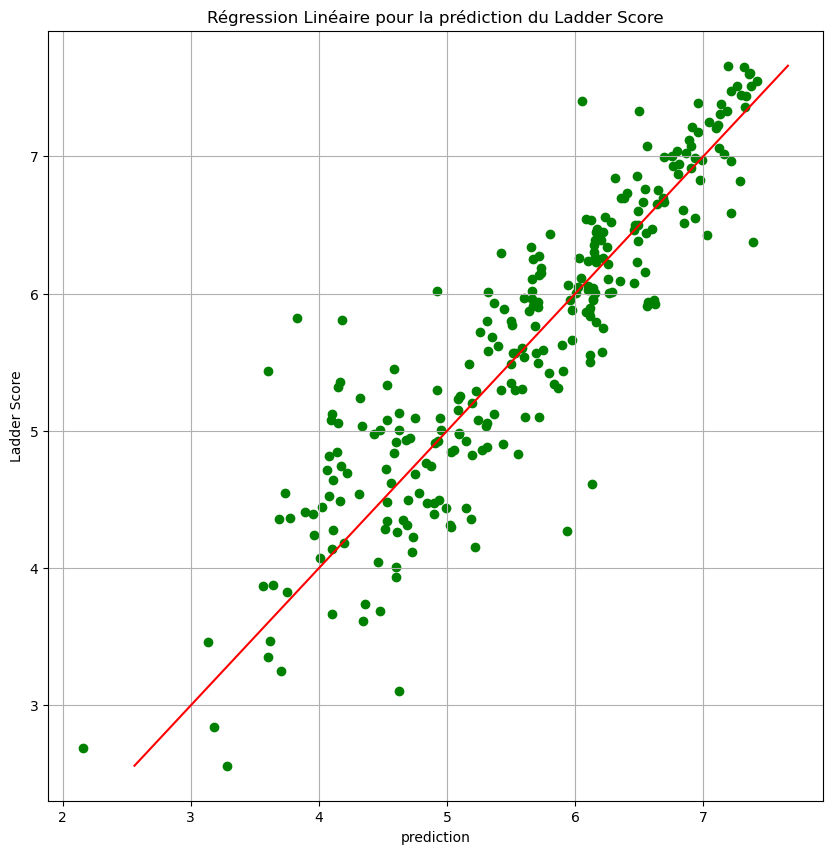

In [113]:
# initialisation et fit du modèle Linear Regressor
lr = LinearRegression()

lr.fit(X_train, y_train)

# visualisation

fig = plt.figure(figsize = (10,10))
pred_test = lr.predict(X_test)
plt.scatter(pred_test, y_test, c='green')

plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), color = 'red')
plt.xlabel("prediction")
plt.ylabel("Ladder Score")
plt.grid()
plt.title('Régression Linéaire pour la prédiction du Ladder Score');

In [14]:
print(lr.intercept_)

print(lr.coef_[0])

-3.8953567805494895
0.28859989260745084


#### Decision Tree Regressor

In [141]:
from sklearn.tree import DecisionTreeRegressor

dt_reg= DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)

y_pred_test = dt_reg.predict(X_test)
print("score train:", dt_reg.score(X_train,y_train))
print ("score test:", dt_reg.score(X_test,y_test))

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


score train: 1.0
score test: 0.7295433088075189
Mean Absolute Error: 0.4108909632942893
Mean Squared Error: 0.3096789745495138
R² Score: 0.7295433088075189


In [139]:
#Test avec données normalisées via différents outils de scaling - pas d'amélioration 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

#scaler = MinMaxScaler()
#scaler = RobustScaler()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)
dt_reg2= DecisionTreeRegressor(random_state=42)
dt_reg2.fit(X_train_scaled, y_train)

y_pred_test2 = dt_reg2.predict(X_test_scaled)
print("score train:", dt_reg2.score(X_train_scaled,y_train))
print ("score test:", dt_reg2.score(X_test_scaled,y_test))

score train: 1.0
score test: 0.7295433088075189


#### Random Forest

In [16]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.983611887453502
0.875385011527584


In [17]:
# Prédictions
y_pred = rf.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error: 0.2773385503031991
Mean Squared Error: 0.14268695543632437
R² Score: 0.875385011527584


#### XGBoost 

In [18]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [75]:
import xgboost as xgb



In [76]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

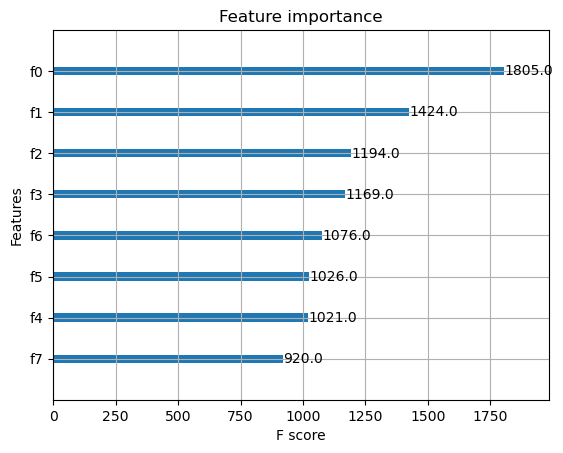

Mean Squared Error (MSE): 0.14
Root Mean Squared Error (RMSE): 0.37
Mean Absolute Error (MAE): 0.27
R^2 Score: 0.88


In [146]:
params = {
    'objective': 'reg:squarederror',  
    'max_depth': 7,                  
    'eta': 0.1,                       
    'subsample': 0.8,                 
    'colsample_bytree': 0.8,          
    'seed': 42      
}
num_boost_round = 150  
model = xgb.train(params, dtrain, num_boost_round)

y_pred = model.predict(dtest)
xgb.plot_importance(model)
plt.show()

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
rmse = np.sqrt(0.14)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

